In [1]:
import numpy as np
import pandas as pd
import geopandas as gd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import loads

In [2]:
fields = gd.read_file('../outputs/fields_shape.shp')
targets = pd.read_csv('../data/targets.csv', index_col='region', thousands=',')

In [3]:
region_codes = ['KR', 'SE', 'SW']
crs = {'init': 'epsg:3857'}

In [4]:
optimal_tables = [pd.read_csv(f'../outputs/optimal_{region_code}.csv') for region_code in region_codes]
all_optimal = pd.concat(optimal_tables, ignore_index=True, sort=False)
all_optimal['geometry'] = all_optimal['geometry'].apply(loads)
fields_optimal = gd.GeoDataFrame(all_optimal, crs={'init': 'epsg:3857'}, geometry=all_optimal['geometry'])

In [5]:
trials_tables = [pd.read_csv(f'../outputs/trials_{region_code}.csv') for region_code in region_codes]
trials = pd.concat(trials_tables, ignore_index=True, sort=False)

In [6]:
plt.rcParams["figure.figsize"] = (20,10)

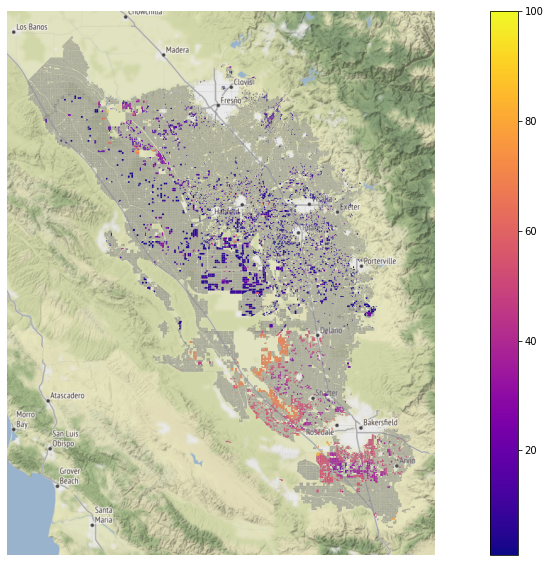

In [7]:
base = fields.plot(color='grey', alpha=0.6)
fields_optimal.plot(ax=base, column='outcome', cmap='plasma', vmin = 1, vmax = 100, legend=True)
ctx.add_basemap(base, url=ctx.sources.ST_TERRAIN, reset_extent=True)
base.set_axis_off()

C:\Users\Erik\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


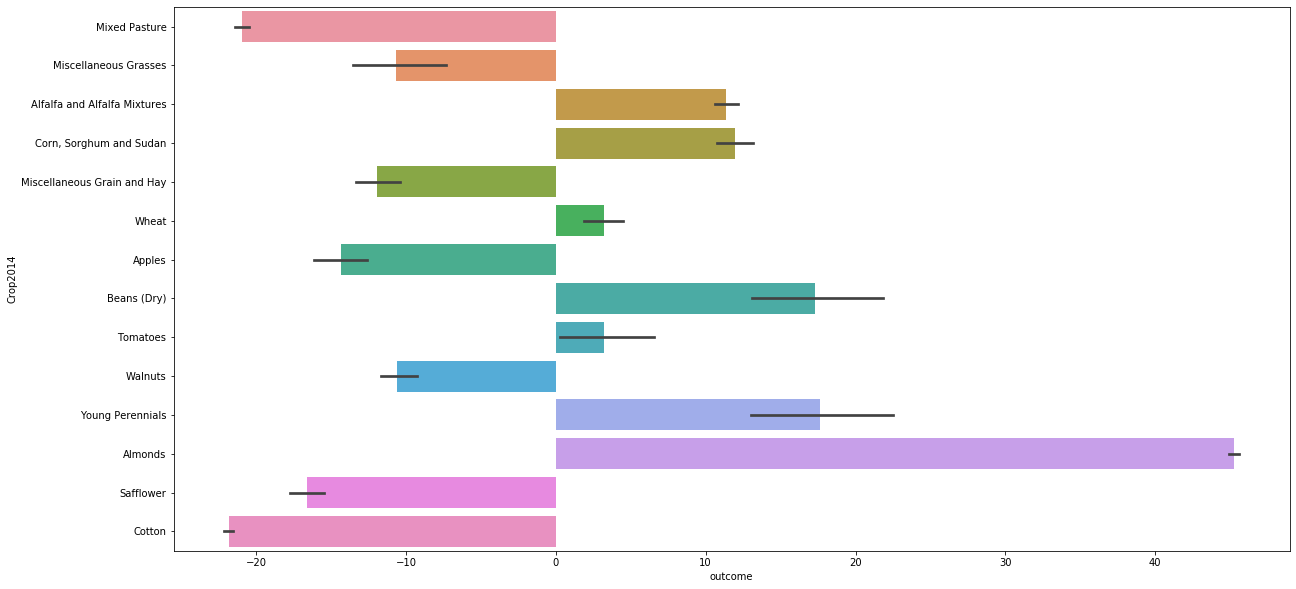

In [8]:
crop_mean_outcome = fields_optimal['outcome'].mean()
sns.barplot(data=fields_optimal, x='outcome', y='Crop2014', estimator = (lambda x: np.mean(x)-crop_mean_outcome), ci=90)

In [9]:
crop_mean_outcome

24.204135123066226

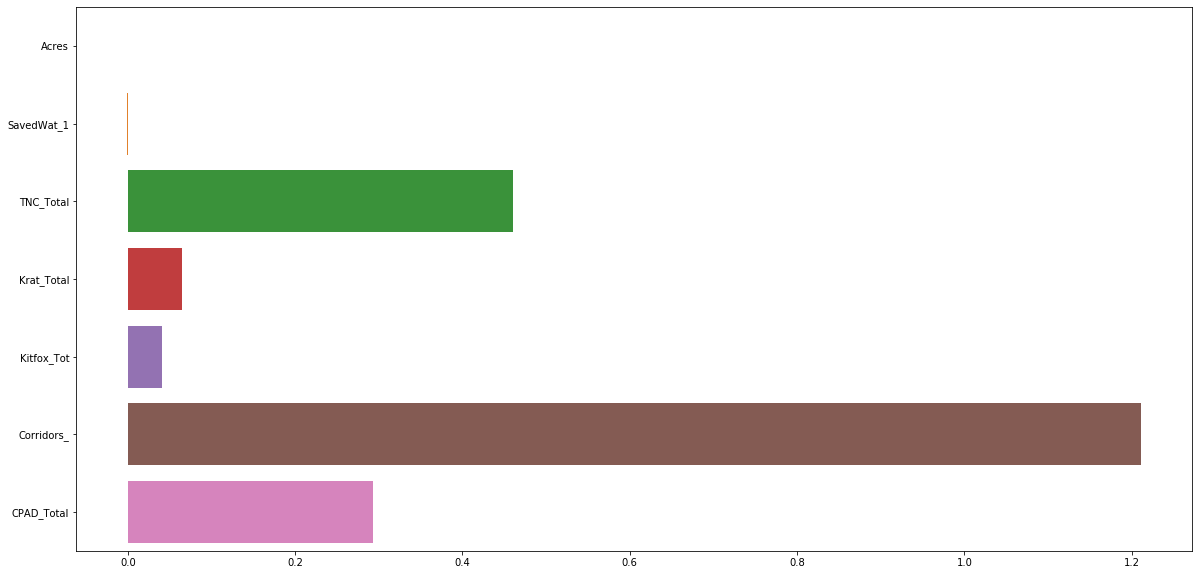

In [21]:
plot_cols = ['Acres', 'SavedWat_1', 'TNC_Total', 'Krat_Total', 'Kitfox_Tot', 'Corridors_',
            'CPAD_Total']  #Exclude FieldCropPrice and optimal
optimal = fields_optimal[plot_cols].sum()
as_usual = trials[plot_cols].mean()*3
pct_chg = (optimal - as_usual)/as_usual
sns.barplot(x = pct_chg, y = fields_optimal[plot_cols].columns)

In [11]:
optimal

Acres         385815.741010
SavedWat_1     62479.804553
TNC_Total      42959.199775
Krat_Total    144669.550848
Kitfox_Tot    168320.673388
Corridors_     35492.352216
CPAD_Total    169170.196036
dtype: float64

In [12]:
as_usual

Acres         128504.222107
SavedWat_1     20849.026826
TNC_Total       9802.227021
Krat_Total     45278.899969
Kitfox_Tot     53878.183998
Corridors_      5349.147152
CPAD_Total     43605.156056
dtype: float64

In [13]:
fields_optimal[plot_cols].head()

,Acres,SavedWat_1,TNC_Total,Krat_Total,Kitfox_Tot,Corridors_,CPAD_Total
0,76.002196,16.604977,76.002196,76.002196,76.002196,0.0,76.002196
1,49.319529,10.775202,49.319529,49.319529,49.319529,0.0,49.319529
2,33.045659,7.219803,33.045659,33.045659,33.045659,0.0,33.045659
3,18.954615,4.141173,18.954615,18.954615,18.954615,0.0,18.954615
4,16.917084,3.696156,16.917084,16.917084,16.917084,0.0,16.917084


In [14]:
region_code = 'SW'
fields_KR = pd.read_csv(f'../outputs/optimal_{region_code}.csv')
trials_KR = pd.read_csv(f'../outputs/trials_{region_code}.csv')

In [15]:
fields_KR['Acres'].sum()

129640.78328901001

In [16]:
trials_KR['Acres'].mean()

129484.86187979701

In [17]:
region_code = 'SE'
fields_KR = pd.read_csv(f'../outputs/optimal_{region_code}.csv')
trials_KR = pd.read_csv(f'../outputs/trials_{region_code}.csv')

In [20]:
trials['PPIC_Regio'].value_counts()

SW    100
KR    100
SE    100
Name: PPIC_Regio, dtype: int64